In [34]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from layouts import Layout
from layouts.library import surface_code
from layouts.util.mixed import set_freq_groups, set_transmon_target_freqs, set_fluxonium_target_params, sample_params, any_collisions, get_num_collisions

In [12]:
NOTEBOOK_DIR = Path.cwd()

DATA_FOLDER = NOTEBOOK_DIR / "data"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

# Distance-3 surface code

In [4]:
DISTANCE = 3

layout = surface_code(DISTANCE, mixed_layout=True)
set_freq_groups(layout)

GROUP_FREQS = np.array([4.3, 4.7, 5.3, 5.7]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.3, len(GROUP_FREQS))
CHARGE_ENERGY = 1
INDUCT_ENERGY = 1
JOSEPH_ENERGY = 4

set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)
set_fluxonium_target_params(
    layout, 
    charge_energy = CHARGE_ENERGY, 
    induct_energy = INDUCT_ENERGY, 
    joseph_energy=  JOSEPH_ENERGY
)
sample_params(layout, seed=0, resist_var=0)

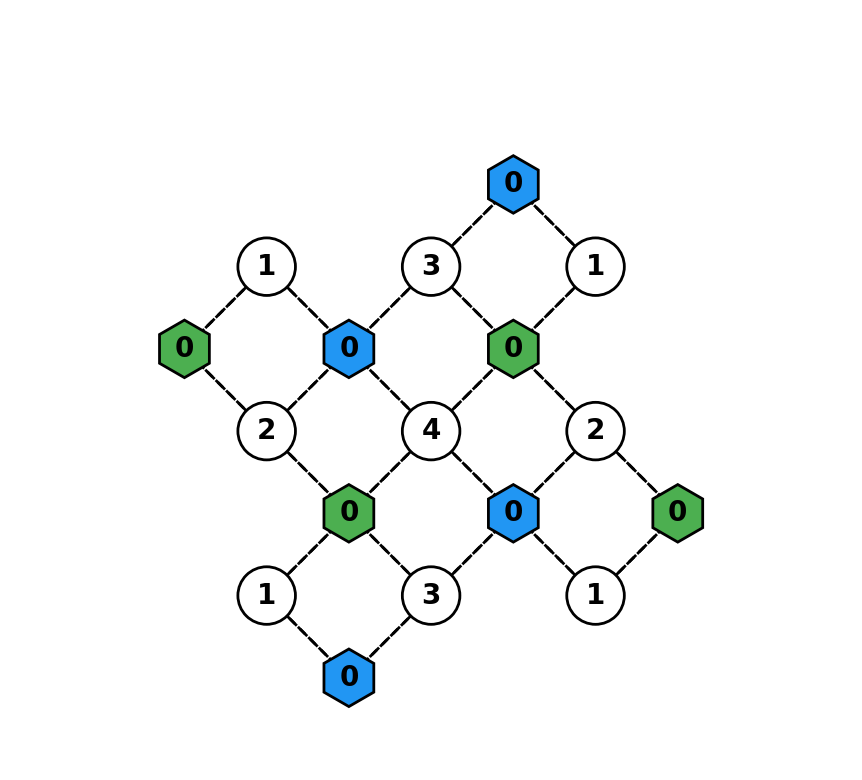

In [5]:
fig, ax = plt.subplots(dpi=200)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

In [ ]:
BOUNDS =  [0.100, 0.060, 0.030, 0.020, 0.030, 0.060]

In [5]:
%%timeit
sample_params(layout, seed = 5, resist_var = 1e-2)
_ = any_collisions(layout, bounds=BOUNDS)

619 ms ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Scan for distance 3

In [7]:
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1
NUM_RES_VARS = 20
NUM_SEEDS = 4000

RES_VARS = np.geomspace(MIN_RES_VAR, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.100, 0.060, 0.030, 0.020, 0.030, 0.060]

result = np.zeros((NUM_RES_VARS, NUM_SEEDS), dtype=int)

for var_ind, res_var in enumerate(RES_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_params(layout, seed, res_var, num_junctions=100, num_fluxonium_levels=6)
        if not any_collisions(layout, BOUNDS):
            result[var_ind, seed_ind] = 1
            
collision_arr = xr.DataArray(
    result,
    dims = ["resist_var", "seed"],
    coords = dict(
        resist_var = RES_VARS,
        seed = SEEDS
    )
)

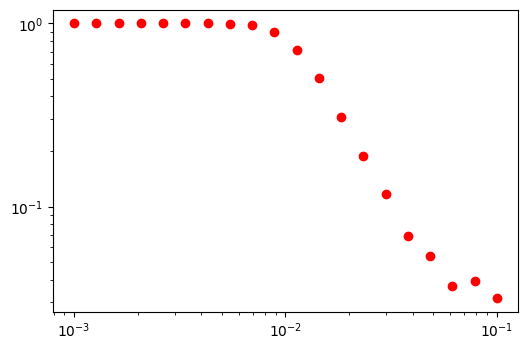

In [8]:
device_yield = collision_arr.mean(dim="seed")

fig, ax = plt.subplots(dpi=100)

ax.scatter(device_yield.resist_var, device_yield, color="red")
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

In [9]:
MAX_RES_VAR = 8e-2
NUM_RES_VARS = 20
NUM_SEEDS = 1000

RES_VARS = np.geomspace(1e-3, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

In [11]:
sampled_collisions = np.zeros((NUM_RES_VARS, NUM_SEEDS, 3), dtype=int)

for var_ind, res_var in enumerate(RES_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_params(layout, seed, res_var)
        sampled_collisions[var_ind, seed_ind] = get_collisions(layout)

In [12]:
total_collisions = sampled_collisions.sum(axis = 2)
collision_stats = sampled_collisions.sum(axis = 1)
device_yield = np.mean(total_collisions == 0, axis= 1)

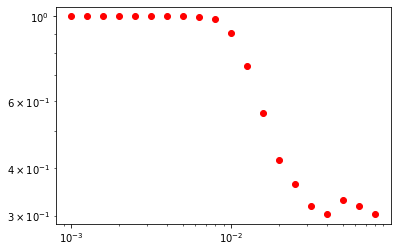

In [13]:
fig, ax = plt.subplots()

ax.scatter(RES_VARS, device_yield, color="red")
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

# Scan with distance as well

In [23]:
notebook_dir = Path.cwd()
DATA_FOLDER = notebook_dir / "data"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

In [10]:
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1
NUM_RES_VARS = 20
NUM_SEEDS = 10000

DISTANCES = [3, 5, 7]
RES_VARS = np.geomspace(MIN_RES_VAR, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.100, 0.060, 0.030, 0.020, 0.030, 0.060]

In [25]:
for dist_ind, distance in enumerate(DISTANCES):
    result = np.zeros((NUM_RES_VARS, NUM_SEEDS), dtype=int)
    
    layout = surface_code(distance, mixed_layout=True)
    set_freq_groups(layout)

    set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)
    set_fluxonium_target_params(
        layout, 
        charge_energy = CHARGE_ENERGY, 
        induct_energy = INDUCT_ENERGY, 
        joseph_energy=  JOSEPH_ENERGY
    )

    for var_ind, res_var in enumerate(RES_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_params(layout, seed, res_var, num_junctions=100, num_fluxonium_levels=6)
            if not any_collisions(layout, BOUNDS):
                result[var_ind, seed_ind] = 1
                
    collision_arr = xr.DataArray(
        result,
        dims = ["resist_var", "seed"],
        coords = dict(
            distance = distance,
            resist_var = RES_VARS,
            seed = SEEDS
        )
    )
    
    data_arr_name = f"mixed_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v2.nc"
    collision_arr.to_netcdf(DATA_FOLDER/data_arr_name)

7


In [26]:
collision_arrays = []

notebook_dir = Path.cwd()
data_folder = notebook_dir / "data"
data_folder.mkdir(parents=True, exist_ok=True)
    
for distance in [3, 5, 7]:
    da_name = f"mixed_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v2.nc"
    array = xr.load_dataarray(DATA_FOLDER/da_name)
    collision_arrays.append(array)
    
full_collision_arr = xr.concat(collision_arrays, dim="distance")

In [27]:
device_yield = full_collision_arr.mean(dim="seed")

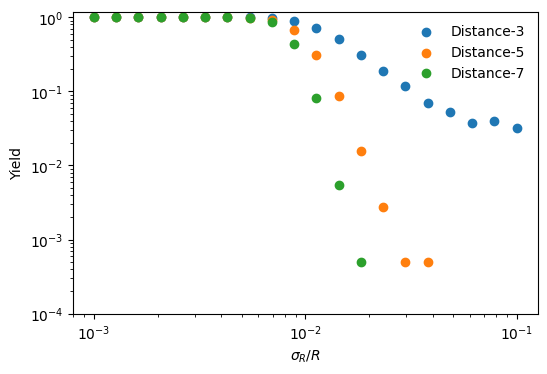

In [32]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.resist_var, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-4)
#ax.set_xlim(1e-3, 1e-1)
ax.legend(frameon=False)

plt.show()

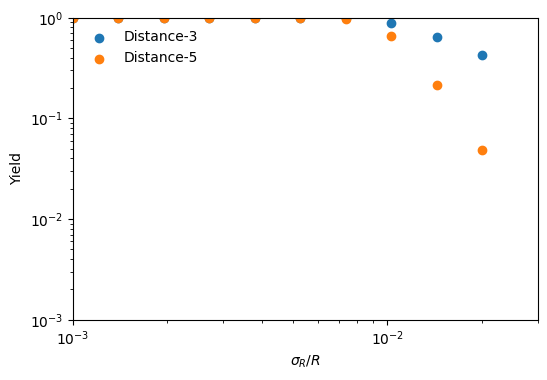

In [17]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.resist_var, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1)
ax.set_xlim(1e-3, 3e-2)
ax.legend(frameon=False)

plt.show()

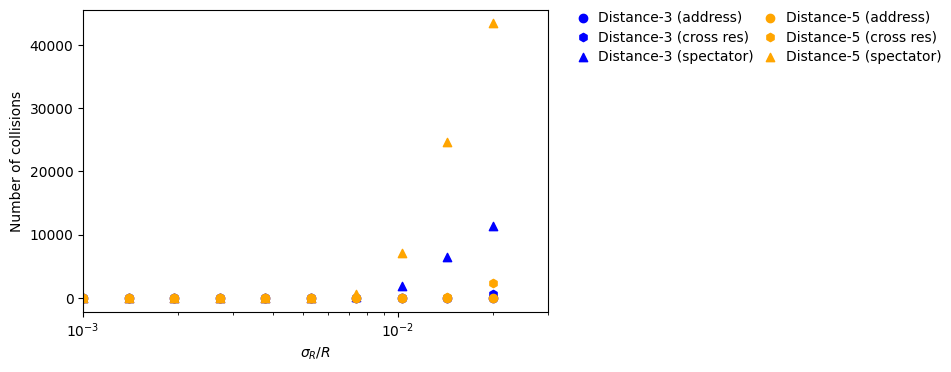

In [31]:
fig, ax = plt.subplots(dpi=100)

markers = dict(
    address = "o",
    cross_res = "h",
    spectator = "^"
)

colors = dict(dist_3 = "blue", dist_5 = "orange", dist_7 = "green")

for dist in collision_stats.distance.values:
    color = colors[f"dist_{dist}"]
    for col_type in collision_stats.collision_type.values:
        
        col_label = "cross res" if col_type == "cross_res" else col_type
        label = f"Distance-{dist} ({col_label})"
        ax.scatter(
            collision_stats.resist_var, 
            collision_stats.sel(distance=dist, collision_type=col_type),
            label=label,
            color=color,
            marker = markers[col_type]
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Number of collisions")
ax.set_xlim(1e-3, 3e-2)
ax.legend(
    frameon=False, 
    ncol=2,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    borderpad=0,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4
)

plt.show()

In [177]:
SAVE_DATA = False

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)

# INVESTIGATE COLLISION TYPE

In [35]:
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1
NUM_RES_VARS = 20
NUM_SEEDS = 10000
NUM_COLLISION_TYPES = 7
DISTANCE = 3
RES_VARS = np.geomspace(MIN_RES_VAR, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.100, 0.060, 0.030, 0.020, 0.030, 0.060]

result = np.zeros((NUM_RES_VARS, NUM_SEEDS, NUM_COLLISION_TYPES), dtype=int)

layout = surface_code(DISTANCE, mixed_layout=True)
set_freq_groups(layout)

set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)
set_fluxonium_target_params(
    layout, 
    charge_energy = CHARGE_ENERGY, 
    induct_energy = INDUCT_ENERGY, 
    joseph_energy=  JOSEPH_ENERGY
)

for var_ind, res_var in enumerate(RES_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_params(layout, seed, res_var, num_junctions=100, num_fluxonium_levels=6)
        result[var_ind, seed_ind] = get_num_collisions(layout, BOUNDS)

num_collision_arr = xr.DataArray(
    result,
    dims = ["resist_var", "seed", "collision_ind"],
    coords = dict(
        distance = DISTANCE,
        resist_var = RES_VARS,
        seed = SEEDS
    )
)

data_arr_name = f"mixed_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_num_collisions_scan.nc"
num_collision_arr.to_netcdf(DATA_FOLDER/data_arr_name)

In [45]:
collision_stats = num_collision_arr.mean(dim="seed")

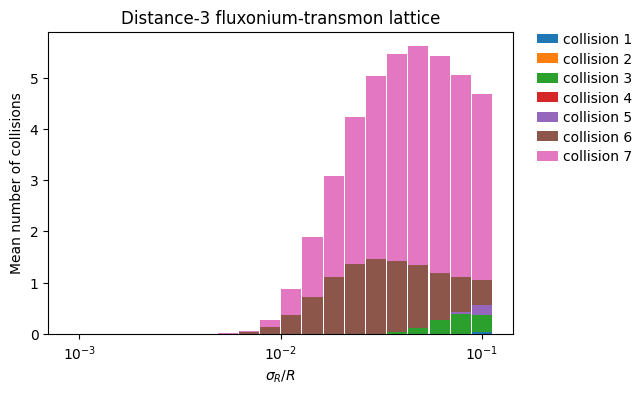

In [246]:
from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(dpi=100)

bar_width = 0.1
#blues_cmap = LinearSegmentedColormap.from_list(
#    name="custom_cmap", 
#    colors=["#e3f2fd", "#bbdefb", "#90caf9", "#64b5f6", "#42a5f5", "#2196f3", "#1e88e5", "#1976d2", "#1565c0", "#0d47a1"]
#)
bar_bottom = np.zeros(NUM_RES_VARS, dtype=float)
resist_vars = collision_statistic.resist_var.values

#ax.set_prop_cycle(
#    color=blues_cmap(np.linspace(0, 1, 7))
#)

colors = ["#f44336", "#ff9800", "#ffeb3b", "#4caf50", "#00bcd4", "#2196f3", "#9c27b0"]


for ind in range(NUM_COLLISION_TYPES):
    collisions = collision_stats.isel(collision_ind = ind).values
    ax.bar(
        np.log10(resist_vars), 
        collisions,  
        width=bar_width, 
        bottom=bar_bottom, 
        label=f"collision {ind + 1}",
        align="center",
    )
    bar_bottom = collisions

ax.set_ylabel('Mean number of collisions')

ax.set_xlabel(r"$\sigma_{R}/R$")
xtick_vals = -np.arange(1, 4)
ax.set_xticks(xtick_vals)
ax.set_xticklabels([f"$10^{{{val}}}$" for val in xtick_vals])

ax.set_title('Distance-3 fluxonium-transmon lattice')

ax.legend(
    frameon=False, 
    ncol=1,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    borderpad=0,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4
)
plt.show()

# Some analysis

In [306]:
from scipy import stats
res_var = 1e-2
freq_var = 0.5*res_var

control_04_freq = 9.864473236189298
target_freq = 5.3
spec_freq = 4.7

target_std = target_freq * freq_var
spec_std = spec_freq * freq_var

combined_mean = target_freq + spec_freq - control_04_freq
combined_std = np.sqrt(target_std**2 + spec_std**2)

dist = stats.norm(combined_mean, combined_std)

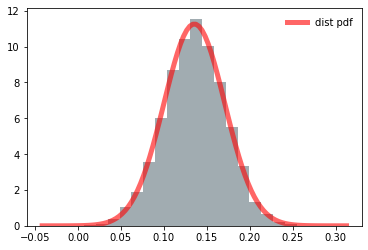

In [307]:
fig, ax = plt.subplots()
r = dist.rvs(size=10000)
x = np.linspace(combined_mean - 5*combined_std, combined_mean + 5*combined_std, 100)
ax.plot(x, dist.pdf(x), 'r-', lw=5, alpha=0.6, label='dist pdf')
ax.hist(r, density=True, histtype='stepfilled', alpha=0.5, bins=20, color="#455a64")
ax.legend(loc='best', frameon=False)
plt.show()

In [310]:
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1
NUM_RES_VARS = 20

RES_VARS = np.geomspace(MIN_RES_VAR, MAX_RES_VAR, NUM_RES_VARS)

n_anc = 4
n_pairs = 2

res = []
for res_var in RES_VARS:
    freq_var = 0.5*res_var
    target_std = target_freq * freq_var
    spec_std = spec_freq * freq_var
    
    combined_mean = target_freq + spec_freq - control_04_freq
    combined_std = np.sqrt(target_std**2 + spec_std**2)
    
    dist = stats.norm(combined_mean, combined_std)
    
    
    res.append((1 - dist.cdf(0))**(n_anc*n_pairs))

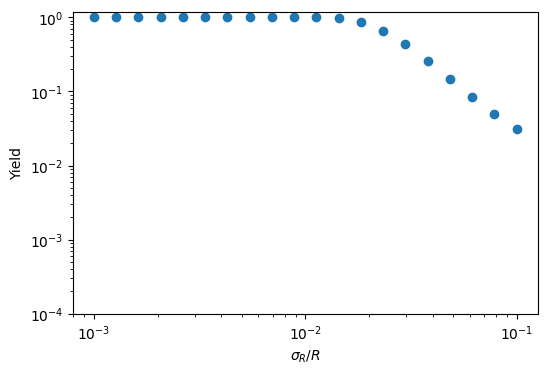

In [312]:
fig, ax = plt.subplots(dpi=100)


ax.scatter(
    RES_VARS, 
    res,
)
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-4)
#ax.set_xlim(1e-3, 1e-1)

plt.show()